# CS224N: Hugging Face Transformers Tutorial (Spring '24)
Original Author: Ben Newman

Thanks to Anna Goldie for feedback!

This notebook will give an introduction to the Hugging Face Transformers Python library and some common patterns that you can use to take advantage of it. It is most useful for using or fine-tuning pretrained transformer models for your projects.


Hugging Face provides access to models (both the code that implements them and their pre-trained weights, including latest LLMs like Llama3, DBRX, etc), model-specific tokenizers, as well as pipelines for common NLP tasks, and datasets and metrics in a separate `datasets` package. It has implementations in PyTorch, Tensorflow, and Flax (though we'll be using the PyTorch versions here!)


We're going to go through a few use cases:
* Overview of Tokenizers and Models
* Finetuning - for your own task. We'll use a sentiment-classification example.

Here are additional resources introducing the library that were used to make this tutorial:

* [Hugging Face Docs](https://huggingface.co/docs/transformers/index)
  * Clear documentation
  * Tutorials, walk-throughs, and example notebooks
  * List of available models
* [Hugging Face Course](https://huggingface.co/course/)
* [Hugging Face Examples](https://github.com/huggingface/transformers/tree/main/examples/pytorch) You can find very similar code structures accross very different downstream tasks/models using Huggingface.
* [Hugging Face O'Reilly Book](https://www.oreilly.com/library/view/natural-language-processing/9781098103231/)



In [26]:
!pip install transformers
!pip install datasets
!pip install accelerate

In [27]:
from collections import defaultdict, Counter
import json

from matplotlib import pyplot as plt
import numpy as np
import torch

def print_encoding(model_inputs, indent=4):
    indent_str = " " * indent
    print("{")
    for k, v in model_inputs.items():
        print(indent_str + k + ":")
        print(indent_str + indent_str + str(v))
    print("}")

## Part 0: Common Pattern for using Hugging Face Transformers

We're going to start off with a common usage pattern for Hugging Face Transformers, using the example of Sentiment Analysis.

First, find a model on [the hub](https://huggingface.co/models). Anyone can upload their model for other people to use. (I'm using a sentiment analysis model from [this paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3489963)).

Then, there are two objects that need to be initialized - a **tokenizer**, and a **model**

* Tokenizer converts strings to lists of vocabulary ids that the model requires
* Model takes the vocabulary ids and produces a prediction

![full_nlp_pipeline.png](https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter2/full_nlp_pipeline.svg)
From [https://huggingface.co/course/chapter2/2?fw=pt](https://huggingface.co/course/chapter2/2?fw=pt)

In [28]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("siebert/sentiment-roberta-large-english")
# Initialize the model
model = AutoModelForSequenceClassification.from_pretrained("siebert/sentiment-roberta-large-english")

In [29]:
inputs = "I'm excited to learn about Hugging Face Transformers!"
tokenized_inputs = tokenizer(inputs, return_tensors="pt")
outputs = model(**tokenized_inputs)

labels = ['NEGATIVE', 'POSITIVE']
prediction = torch.argmax(outputs.logits)


print("Input:")
print(inputs)
print()
print("Tokenized Inputs:")
print_encoding(tokenized_inputs)
print()
print("Model Outputs:")
print(outputs)
print()
print(f"The prediction is {labels[prediction]}")

Input:
I'm excited to learn about Hugging Face Transformers!

Tokenized Inputs:
{
    input_ids:
        tensor([[    0,   100,   437,  2283,     7,  1532,    59, 30581,  3923, 12346,
         34379,   328,     2]])
    attention_mask:
        tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
}

Model Outputs:
SequenceClassifierOutput(loss=None, logits=tensor([[-3.7605,  2.9262]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

The prediction is POSITIVE


### **0.1 Tokenizers (TO-DO)**

Pretrained models are implemented along with **tokenizers** that are used to preprocess their inputs. The tokenizers take raw strings or list of strings and output what are effectively dictionaries that contain the the model inputs.


You can access tokenizers either with the Tokenizer class specific to the model you want to use (here DistilBERT), or with the AutoTokenizer class.
Fast Tokenizers are written in Rust, while their slow versions are written in Python.

In [30]:
from transformers import DistilBertTokenizer, DistilBertTokenizerFast, AutoTokenizer
name = "distilbert/distilbert-base-cased"
# name = "user/name" when loading from
# name = local_path when using save_pretrained() method

tokenizer = AutoTokenizer.from_pretrained(name)
print(tokenizer)

DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)


In [31]:
# This is how you call the tokenizer
input_str = "Hugging Face Transformers is great!"
tokenized_inputs = tokenizer(input_str) # https://huggingface.co/learn/nlp-course/en/chapter6/6


print("Vanilla Tokenization")
print_encoding(tokenized_inputs)
print()

# Two ways to access:
print(tokenized_inputs.input_ids)
print(tokenized_inputs["input_ids"])

Vanilla Tokenization
{
    input_ids:
        [101, 20164, 10932, 10289, 25267, 1110, 1632, 106, 102]
    attention_mask:
        [1, 1, 1, 1, 1, 1, 1, 1, 1]
}

[101, 20164, 10932, 10289, 25267, 1110, 1632, 106, 102]
[101, 20164, 10932, 10289, 25267, 1110, 1632, 106, 102]


#### **Questions**
1. Why those the second token start with '##'?
2. What do the token IDs [CLS] and [SEP] stand for?
  - What are there associated token IDs?
3. Go to the cell above and modify the input_str and observe its use case.
  - Optional: Can you think of edge cases for the tokenizer? (E.g., rare words)
4. What do the vectors of 1s in the attention_mask represent?

In [32]:
cls = [tokenizer.cls_token_id]
sep = [tokenizer.sep_token_id]

# Tokenization happens in a few steps:
input_tokens = tokenizer.tokenize(input_str)
input_ids = tokenizer.convert_tokens_to_ids(input_tokens)
input_ids_special_tokens = cls + input_ids + sep

decoded_str = tokenizer.decode(input_ids_special_tokens)

print("start:                ", input_str)
print("tokenize:             ", input_tokens)
print("convert_tokens_to_ids:", input_ids)
print("add special tokens:   ", input_ids_special_tokens)
print("--------")
print("decode:               ", decoded_str)

# NOTE that these steps don't create the attention mask or add the special characters

start:                 Hugging Face Transformers is great!
tokenize:              ['Hu', '##gging', 'Face', 'Transformers', 'is', 'great', '!']
convert_tokens_to_ids: [20164, 10932, 10289, 25267, 1110, 1632, 106]
add special tokens:    [101, 20164, 10932, 10289, 25267, 1110, 1632, 106, 102]
--------
decode:                [CLS] Hugging Face Transformers is great! [SEP]


In [33]:
# You can pass multiple strings into the tokenizer and pad them as you need
model_inputs = tokenizer(["Hugging Face Transformers is great!",
                         "The quick brown fox jumps over the lazy dog." +\
                         "Then the dog got up and ran away because she didn't like foxes.",
                         ],
                         return_tensors="pt",
                         padding=True,
                         truncation=True)
print(f"Pad token: {tokenizer.pad_token} | Pad token id: {tokenizer.pad_token_id}")
print("Padding:")
print_encoding(model_inputs)

Pad token: [PAD] | Pad token id: 0
Padding:
{
    input_ids:
        tensor([[  101, 20164, 10932, 10289, 25267,  1110,  1632,   106,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  1109,  3613,  3058, 17594, 15457,  1166,  1103, 16688,  3676,
           119,  1599,  1103,  3676,  1400,  1146,  1105,  1868,  1283,  1272,
          1131,  1238,   112,   189,  1176, 17594,  1279,   119,   102]])
    attention_mask:
        tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]])
}


In [34]:
# You can also decode a whole batch at once:
print("Batch Decode:")
print(tokenizer.batch_decode(model_inputs.input_ids))
print()
print("Batch Decode: (no special characters)")
print(tokenizer.batch_decode(model_inputs.input_ids, skip_special_tokens=True))

Batch Decode:
['[CLS] Hugging Face Transformers is great! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', "[CLS] The quick brown fox jumps over the lazy dog. Then the dog got up and ran away because she didn ' t like foxes. [SEP]"]

Batch Decode: (no special characters)
['Hugging Face Transformers is great!', "The quick brown fox jumps over the lazy dog. Then the dog got up and ran away because she didn ' t like foxes."]


For more information about tokenizers, you can look at:
[Hugging Face Transformers Docs](https://huggingface.co/docs/transformers/main_classes/tokenizer) and the [Hugging Face Tokenizers Library](https://huggingface.co/docs/tokenizers/python/latest/quicktour.html) (For the Fast Tokenizers). The Tokenizers Library even lets you train your own tokenizers!

### 0.2 Models




Initializing models is very similar to initializing tokenizers. You can either use the model class specific to your model or you can use an AutoModel class. I tend to prefer AutoModel, especially when I want to compare models, because it's easy to specify the models as strings.

While most of the pretrained transformers have similar architecture, if you there are additional weights, called "heads" that you have to train if you're doing sequence classification, question answering, or some other task. Hugging Face automatically sets up the architecture you need when you specify the model class. For example, we are doing sentiment analysis, so we are going to use `DistilBertForSequenceClassification`. If we were going to continue training DistilBERT on its masked-language modeling training objective, we would use `DistilBertForMaskedLM`, and if we just wanted the model's representations, maybe for our own downstream task, we could just use `DistilBertModel`.


Here's a stylized picture of a model recreated from one found here: [https://huggingface.co/course/chapter2/2?fw=pt](https://huggingface.co/course/chapter2/2?fw=pt).
![model_illustration.png](https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter2/transformer_and_head.svg)


Here are some examples.
```
*Model
*ForMaskedLM
*ForSequenceClassification
*ForTokenClassification
*ForQuestionAnswering
*ForMultipleChoice
...
```
where `*` can be `AutoModel` or a specific pretrained model (e.g. `DistilBert`)


There are three types of models:
* Encoders (e.g. BERT)
* Decoders (e.g. GPT2)
* Encoder-Decoder models (e.g. BART or T5)

The task-specific classes you have available depend on what type of model you're dealing with.


A full list of choices are available in the [docs](https://huggingface.co/docs/transformers/model_doc/auto). Note that not all models are compatible with all model architectures, for example DistilBERT is not compatible with the Seq2Seq models because it only consists of an encoder.


In [35]:
from transformers import AutoModelForSequenceClassification, DistilBertForSequenceClassification, DistilBertModel
print("Loading classification model from base model's checkpoint")
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)


Loading classification model from base model's checkpoint


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
model_inputs = tokenizer(input_str, return_tensors="pt")

model_outputs = model(input_ids=model_inputs.input_ids, attention_mask=model_inputs.attention_mask)

print(model_inputs)
print()
print(model_outputs)
print()
print(f"Distribution over labels: {torch.softmax(model_outputs.logits, dim=1)}")

{'input_ids': tensor([[  101, 20164, 10932, 10289, 25267,  1110,  1632,   106,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}

SequenceClassifierOutput(loss=None, logits=tensor([[-0.1220,  0.0460]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

Distribution over labels: tensor([[0.4581, 0.5419]], grad_fn=<SoftmaxBackward0>)


['[CLS]', 'Hu', '##gging', 'Face', 'Transformers', 'is', 'great', '!', '[SEP]']


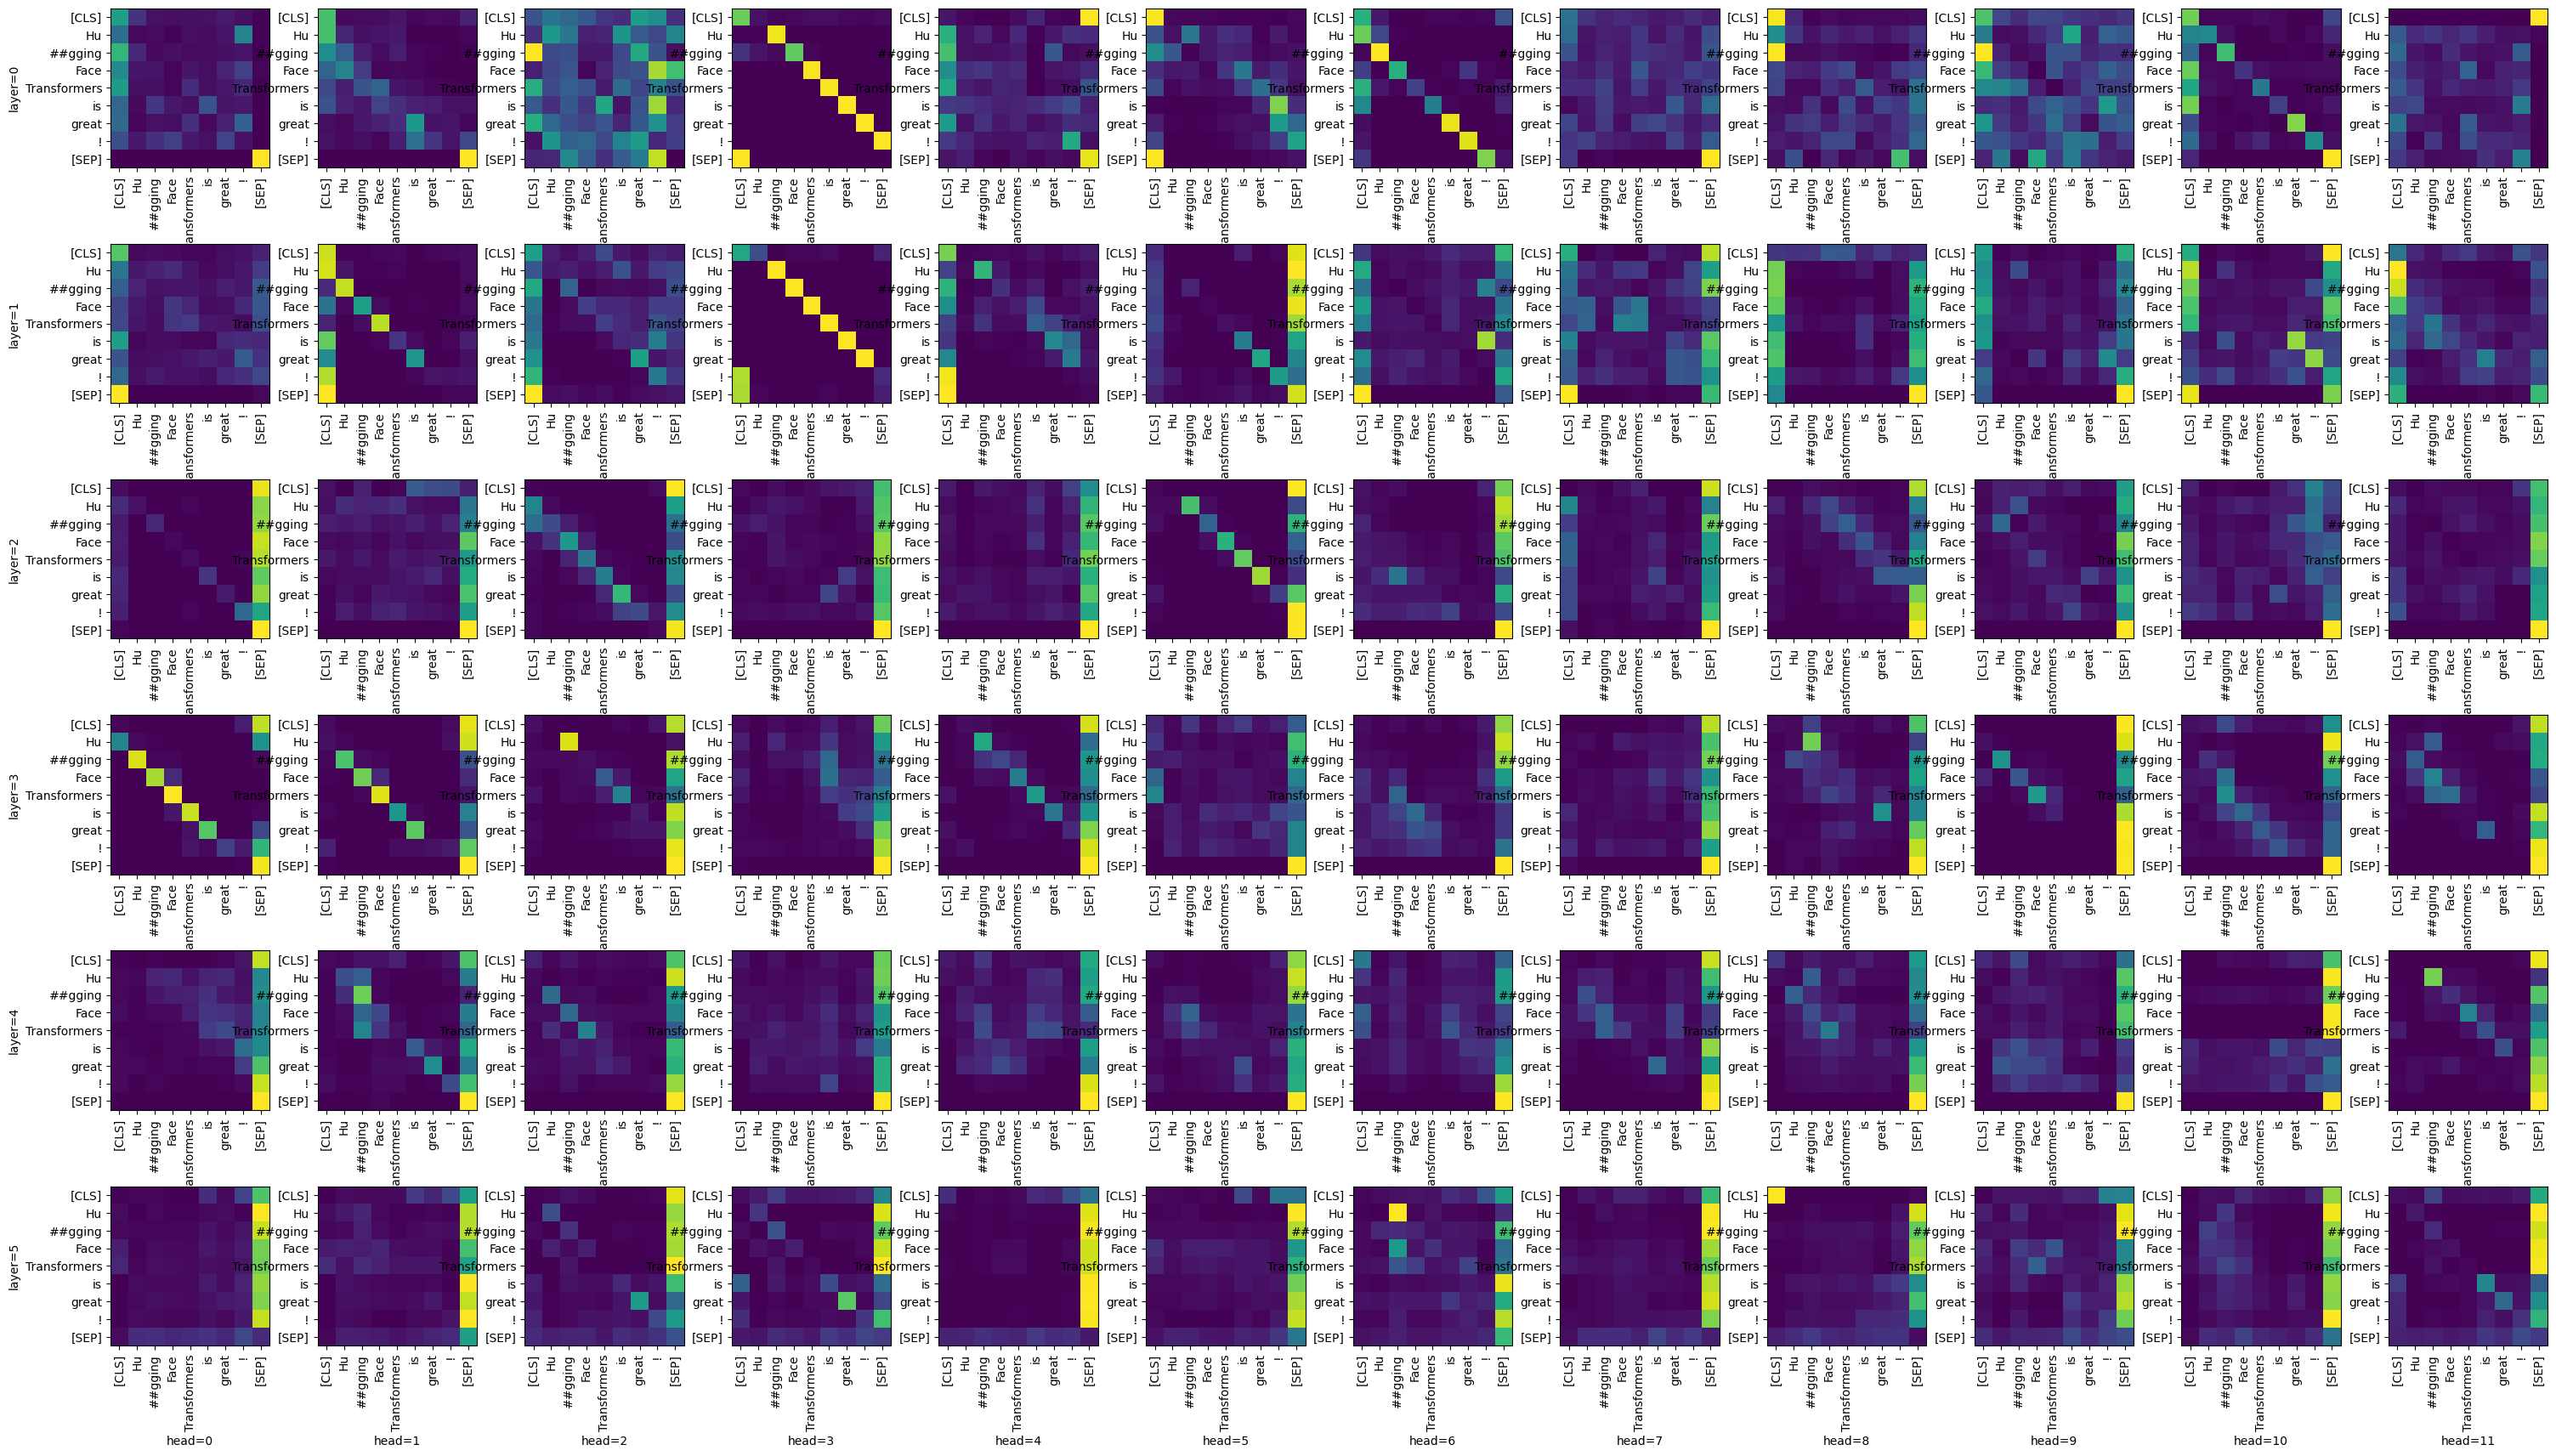

In [37]:
tokens = tokenizer.convert_ids_to_tokens(model_inputs.input_ids[0])
print(tokens)


n_layers = len(model_output.attentions)
n_heads = len(model_output.attentions[0][0])
fig, axes = plt.subplots(6, 12)
fig.set_size_inches(18.5*2, 10.5*2)
for layer in range(n_layers):
    for i in range(n_heads):
        axes[layer, i].imshow(model_output.attentions[layer][0, i])
        axes[layer][i].set_xticks(list(range(9)))
        axes[layer][i].set_xticklabels(labels=tokens, rotation="vertical")
        axes[layer][i].set_yticks(list(range(9)))
        axes[layer][i].set_yticklabels(labels=tokens)

        if layer == 5:
            axes[layer, i].set(xlabel=f"head={i}")
        if i == 0:
            axes[layer, i].set(ylabel=f"layer={layer}")

plt.subplots_adjust(wspace=0.3)
plt.show()

## Appendix 0: Generation

In the example above we finetuned the model on a classification task, but you can also finetune models on generation tasks. The `generate` function makes it easy to generate from these models. For example.

In [38]:
from transformers import AutoModelForCausalLM

gpt2_tokenizer = AutoTokenizer.from_pretrained('gpt2')

gpt2 = AutoModelForCausalLM.from_pretrained('distilgpt2')
gpt2.config.pad_token_id = gpt2.config.eos_token_id  # Prevents warning during decoding

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [39]:
prompt = "Once upon a time"

tokenized_prompt = gpt2_tokenizer(prompt, return_tensors="pt")

for i in range(10):
    output = gpt2.generate(**tokenized_prompt,
                  max_length=50,
                  do_sample=True,
                  top_p=0.9)

    print(f"{i + 1}) {gpt2_tokenizer.batch_decode(output)[0]}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1) Once upon a time of war, in one of the most dramatic tragedies of all time, one could see the aftermath of the German defeat of Adolf Hitler in 1945. And a few weeks after the war was over, a German soldier died. The German


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2) Once upon a time in the past, I'd have no idea how much I'm doing, but now I've just told my mom to tell me that I don't want to be alone with me. It's a sad, embarrassing decision.



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


3) Once upon a time in the past, these individuals were a key element in shaping society and society.



When you ask, ‪what do you mean by 'a good man?' and you are not sure what that means, �


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


4) Once upon a time, and I can't deny my love for him, I felt compelled to take a close look at the little girls. I've been able to make it out to be this way since it happened, and as a result my love


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


5) Once upon a time of war, the people of Yemen have become too dangerous for a country's security forces to maintain. There are many who think Yemen would be easier to attack than the United States or other international powers.



It would


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


6) Once upon a time of need, these were the first instances where we really needed each other and our other, not just to help each other but to support each other. We also needed to make sure we knew each other, and each other, as


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


7) Once upon a time of year, there was no such thing as a great deal of time to do for my kids. So when it was decided that I would take a break to take my children to a beach on Valentine's Day, and it was


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


8) Once upon a time, it is a miracle to be able to move. It is a miracle to be able to do so, and then there is no other way, but one way.

You can see a full list of the achievements for


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


9) Once upon a time of high pressure.

That's why, as we discuss the importance of taking care of yourself, it's important to keep yourself clear about your thoughts on how much you care about others, and how you're aware of what
10) Once upon a time, however, we will return to the roots of our culture.”

This article first appeared in our January 2015 issue of the Huffington Post.<|endoftext|>


## Appendix 2: Pipelines

There are some standard NLP tasks like sentiment classification or question answering where there are already pre-trained (and fine-tuned!) models available through Hugging Face Transformer's [_Pipeline_](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/pipelines#transformers.pipeline) interface.

For your projects, you likely won't be using it too much, but it's still worth knowing about!

Here's an example with Sentiment Analysis:

In [40]:
from transformers import pipeline

sentiment_analysis = pipeline("sentiment-analysis", model="siebert/sentiment-roberta-large-english")

Device set to use cuda:0


You can run the pipeline by just calling it on a string

In [41]:
sentiment_analysis("Hugging Face Transformers is really cool!")

[{'label': 'POSITIVE', 'score': 0.998448371887207}]

Or on a list of strings:

In [42]:
sentiment_analysis(["I didn't know if I would like Hákarl, but it turned out pretty good.",
                    "I didn't know if I would like Hákarl, and it was just as bad as I'd heard."])

[{'label': 'POSITIVE', 'score': 0.9988769888877869},
 {'label': 'NEGATIVE', 'score': 0.9994940757751465}]

You can find more information on pipelines (including which ones are available) [here](https://huggingface.co/docs/transformers/main_classes/pipelines)